In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

In [2]:
class LDA:

    def __init__(self, X=None, y=None):

        self.__m0 = None
        self.__m1 = None
        self.__pi_1 = None
        self.__cov_matrix = None
        if X is not None and y is not None:
            self.fit(X, y)
        elif (X is None and y is not None) or (X is not None and y is None):
            raise Exception("Pass both X and y")


    def fit(self, X, y):

        def __estimate_m0():
            return X[y == 0].mean(axis=0).to_numpy()

        def __estimate_m1():
            return X[y == 1].mean(axis=0).to_numpy()
        
        def __estimate_pi_1():
            return sum(y == 1) / len(y)
        
        self.__m0 = __estimate_m0()
        self.__m1 = __estimate_m1()
        self.__pi_1 = __estimate_pi_1()
        self.__cov_matrix = pd.DataFrame(X).cov().to_numpy()


    def get_params(self, param=None):

        if param is None:
            params = {
                'm0': self.__m0,
                'm1': self.__m1,
                'pi_1': self.__pi_1,
                'cov_matrix': self.__cov_matrix
            }
            return params
        elif param == 'm0':
            return self.__m0
        elif param == 'm1':
            return self.__m1
        elif param == 'pi_1' or param == 'pi1':
            return self.__pi_1
        elif param == 'cov_matrix':
            return self.__cov_matrix
        
        return None
    

    def predict_proba(self, Xtest):
        def predict_proba_one_bservation(x):
            inverse = np.linalg.inv(self.__cov_matrix)
            e0 = np.exp(np.dot(np.dot(-0.5 * (x - self.__m0), inverse), x - self.__m0))
            e1 = np.exp(np.dot(np.dot(-0.5 * (x - self.__m1), inverse), x - self.__m1))
            p0 = e0 * (1 - self.__pi_1) / (e0 * (1 - self.__pi_1) + e1 * self.__pi_1)
            return [p0, 1 - p0]

        probas = []
        for x in Xtest:
            probas.append(predict_proba_one_bservation(x))

        return np.array(probas)
    
    
    def predict(self, Xtest):
        def __response():
            n = len(Xtest)
            inverse = np.linalg.inv(self.__cov_matrix)
            a = np.array([math.log((1 - self.__pi_1) / self.__pi_1)] * n)
            b = np.dot(np.dot((self.__m0 - self.__m1), inverse), Xtest.T)
            c = np.dot(np.dot(-0.5 * (self.__m0 - self.__m1), inverse), self.__m0 + self.__m1)
            return a + b + c
        
        return (__response() <= 0).astype(int)
    

class QDA:

    def __init__(self, X=None, y=None):

        self.__m0 = None
        self.__m1 = None
        self.__pi_1 = None
        self.__cov_matrix_0 = None
        self.__cov_matrix_1 = None
        if X is not None and y is not None:
            self.fit(X, y)
        elif (X is None and y is not None) or (X is not None and y is None):
            raise Exception("Pass both X and y")


    def fit(self, X, y):

        def __estimate_m0():
            return X[y == 0].mean(axis=0).to_numpy()

        def __estimate_m1():
            return X[y == 1].mean(axis=0).to_numpy()
        
        def __estimate_pi_1():
            return sum(y == 1) / len(y)
        
        def __estimate_cov_matrix_0():
            return pd.DataFrame(X[y == 0]).cov().to_numpy()
        
        def __estimate_cov_matrix_1():
            return pd.DataFrame(X[y == 1]).cov().to_numpy()
        
        self.__m0 = __estimate_m0()
        self.__m1 = __estimate_m1()
        self.__pi_1 = __estimate_pi_1()
        self.__cov_matrix_0 = __estimate_cov_matrix_0()
        self.__cov_matrix_1 = __estimate_cov_matrix_1()


    def get_params(self, param=None):

        if param is None:
            params = {
                'm0': self.__m0,
                'm1': self.__m1,
                'pi_1': self.__pi_1,
                'cov_matrix_0': self.__cov_matrix_0,
                'cov_matrix_1': self.__cov_matrix_1
            }
            return params
        elif param == 'm0':
            return self.__m0
        elif param == 'm1':
            return self.__m1
        elif param == 'pi_1' or param == 'pi1':
            return self.__pi_1
        elif param == 'cov_matrix_0':
            return self.__cov_matrix_0
        elif param == 'cov_matrix_1':
            return self.__cov_matrix_1
        
        return None

    def predict_proba(self, Xtest):
        inverse_0 = np.linalg.inv(self.__cov_matrix_0)
        det_0 = np.linalg.det(self.__cov_matrix_0)
        inverse_1 = np.linalg.inv(self.__cov_matrix_1)
        det_1 = np.linalg.det(self.__cov_matrix_1)
        probas = []
        for i in range(len(Xtest)):
            x = Xtest.iloc[i].to_numpy()
            p0 = np.exp(-0.5 * np.dot(np.dot(x - self.__m0, inverse_0), (x - self.__m0).T)) / det_0
            p1 = np.exp(-0.5 * np.dot(np.dot(x - self.__m1, inverse_1), (x - self.__m1).T)) / det_1
            p = p0 * (1 - self.__pi_1) / (p0 * (1 - self.__pi_1) + p1 * self.__pi_1)
            probas.append([p, 1 - p])
        return np.array(probas)


    def predict(self, Xtest):
        return (self.predict_proba(Xtest)[:, 0] < 0.5).astype(int)
    
    
class NB:

    def __init__(self, X=None, y=None):

        self.__m0 = None
        self.__m1 = None
        self.__pi_1 = None
        self.__sigma_0 = None
        self.__sigma_1 = None
        if X is not None and y is not None:
            self.fit(X, y)
        elif (X is None and y is not None) or (X is not None and y is None):
            raise Exception("Pass both X and y")


    def fit(self, X, y):

        def __estimate_m0():
            return X[y == 0].mean(axis=0).to_numpy()

        def __estimate_m1():
            return X[y == 1].mean(axis=0).to_numpy()
        
        def __estimate_pi_1():
            return sum(y == 1) / len(y)
        
        def __estimate_sigma_0():
            return np.var(X[y==0], axis=0).to_numpy()
        
        def __estimate_sigma_1():
            return np.var(X[y==1], axis=0).to_numpy()
        
        self.__m0 = __estimate_m0()
        self.__m1 = __estimate_m1()
        self.__pi_1 = __estimate_pi_1()
        self.__sigma_0 = __estimate_sigma_0()
        self.__sigma_1 = __estimate_sigma_1()


    def get_params(self, param=None):

        if param is None:
            params = {
                'm0': self.__m0,
                'm1': self.__m1,
                'pi_1': self.__pi_1,
                'sigma_0': self.__sigma_0,
                'sigma_1': self.__sigma_1
            }
            return params
        elif param == 'm0':
            return self.__m0
        elif param == 'm1':
            return self.__m1
        elif param == 'pi_1' or param == 'pi1':
            return self.__pi_1
        elif param == 'sigma_0':
            return self.__sigma_0
        elif param == 'sigma_1':
            return self.__sigma_1
        
        return None


    def predict_proba(self, Xtest):
        def __row_proba(x):
            p_0, p_1 = 1, 1
            for i in range(len(x)):
                s_0 = self.__sigma_0[i]
                s_1 = self.__sigma_1[i]
                p_0 *= np.exp((-(x[i]-self.__m0[i]) ** 2) / (2 * s_0)) / (s_0 * math.sqrt(2 * math.pi))
                p_1 *= np.exp((-(x[i]-self.__m1[i]) ** 2) / (2 * s_1)) / (s_1 * math.sqrt(2 * math.pi))
            p = p_0 * (1 - self.__pi_1) / (p_0 * (1 - self.__pi_1) + p_1 * self.__pi_1)
            return [p, 1 - p]
        
        probas = []
        for i in range(len(Xtest)):
            x = Xtest.iloc[i].to_numpy()
            probas.append(__row_proba(x))
        
        return np.array(probas)
            

    def predict(self, Xtest):
        probas = self.predict_proba(Xtest)
        response = []
        for i in range(len(Xtest)):
            response.append(int(probas[i][0] < 0.5))
        return np.array(response)



# Task 2

In [13]:
def scheme_1(a, n=1000, p=2, seed=123):
    np.random.seed(seed)
    y = (np.random.uniform(0, 1, size=n) > 0.5).astype(int)
    x_0 = np.random.normal(0, 1, size=(sum(y==0), p))
    x_1 = np.random.normal(a, 1, size=(sum(y==1), p))
    df0 = pd.DataFrame(x_0)
    df1 = pd.DataFrame(x_1)
    df0['target'] = 0
    df1['target'] = 1
    return pd.concat([df0, df1]).reset_index(drop=True)


def scheme_2(a, ro, n=1000, p=2, seed=123):
    np.random.seed(seed)
    y = (np.random.uniform(0, 1, size=n) > 0.5).astype(int)
    x_0 = np.random.multivariate_normal(mean=[0, 0], cov=np.array([[1, ro], [ro, 1]]), size=sum(y==0))
    x_1 = np.random.multivariate_normal(mean=[a, a], cov=np.array([[1, ro * (-1)], [ro * (-1), 1]]), size=sum(y==1))
    df0 = pd.DataFrame(x_0)
    df1 = pd.DataFrame(x_1)
    df0['target'] = 0
    df1['target'] = 1
    return pd.concat([df0, df1]).reset_index(drop=True)


## 2.1

In [14]:
import glob

ro = 0.5
a = [0.1, 0.5, 1, 2, 3, 5]

for i, mean in enumerate(a):
    df = scheme_1(mean, seed=i)
    globals()['X_s1_' + str(i)] = df.iloc[:, :2]
    globals()['y_s1_' + str(i)] = df.iloc[:, 2]
    df = scheme_2(mean, ro, seed=i)
    globals()['X_s2_' + str(i)] = df.iloc[:, :2]
    globals()['y_s2_' + str(i)] = df.iloc[:, 2]

In [7]:
np.random.seed(123)


accuracys = {'LDA': {'scheme_1': dict(), 'scheme_2': dict()}, 
             'QDA': {'scheme_1': dict(), 'scheme_2': dict()},
             'NB': {'scheme_1': dict(), 'scheme_2': dict()}}
for scheme in ['1', '2']:
    for mean in range(len(a)):
        for model in ['LDA', 'QDA', 'NB']:
            for r_state in np.random.randint(1, 50000, size=200):

                X_train, X_test, y_train, y_test = train_test_split(globals()['X_s' + scheme + '_' + str(mean)],
                                                                    globals()['y_s' + scheme + '_' + str(mean)],
                                                                    test_size=0.25, random_state=r_state)

                if model == 'LDA':
                    m = LDA(X_train, y_train)
                elif model == 'QDA':
                    m = QDA(X_train, y_train)
                elif model == 'NB':
                    m = NB(X_train, y_train)

                acc = accuracy_score(m.predict(X_test), y_test)
                if accuracys[model]['scheme_' + scheme].get(a[mean]) is None:
                    accuracys[model]['scheme_' + scheme][a[mean]] = []

                accuracys[model]['scheme_' + scheme][a[mean]].append(acc)

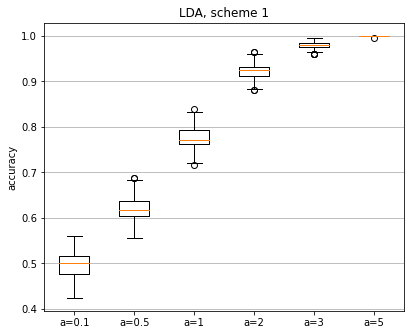

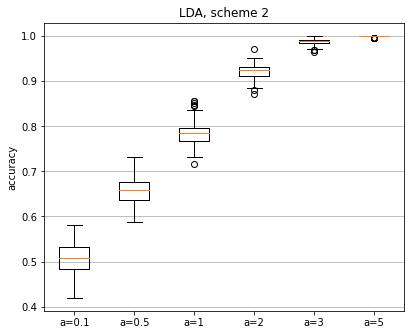

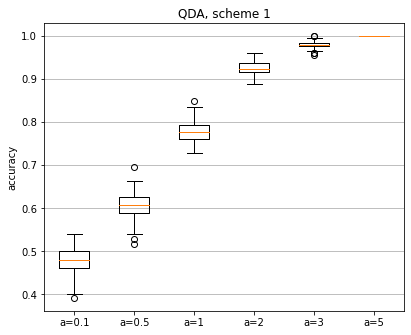

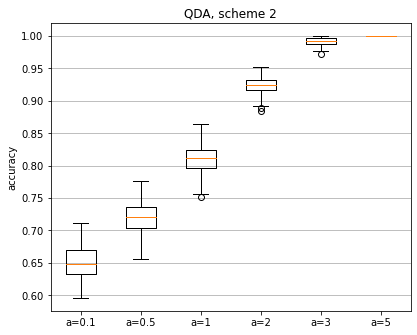

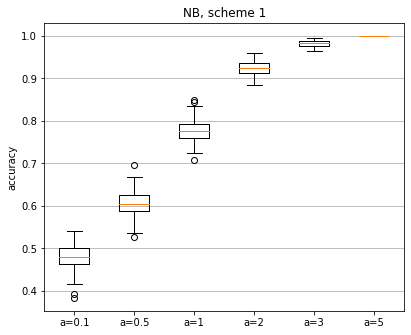

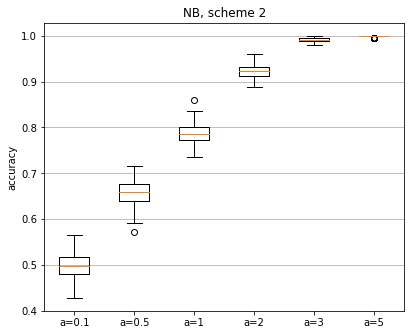

In [13]:
for model in ['LDA', 'QDA', 'NB']:
    for scheme in ['1', '2']:
        x = []
        for mean in range(len(a)):
            x.append(accuracys.get(model).get('scheme_' + scheme).get(a[mean]))

        fig = plt.figure(figsize =(5, 4))
        ax = fig.add_axes([0, 0, 1, 1])
        bp = ax.boxplot(x)
        plt.grid(axis='y')
        plt.title(model + ', scheme ' + scheme)
        ax.set_xticklabels(['a='+str(mean) for mean in a])
        plt.ylabel("accuracy")
        plt.savefig('task2/task_2_1_' + model + '_scheme' + scheme, bbox_inches='tight',
                    facecolor='white', transparent=False, pad_inches=0, dpi=200)
        plt.show()


## 2.2

In [15]:
ro = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
a = 2

for i, r in enumerate(ro):
    df = scheme_1(a, seed=i)
    globals()['X_s1_' + str(i)] = df.iloc[:, :2]
    globals()['y_s1_' + str(i)] = df.iloc[:, 2]
    df = scheme_2(a, r, seed=i)
    globals()['X_s2_' + str(i)] = df.iloc[:, :2]
    globals()['y_s2_' + str(i)] = df.iloc[:, 2]

In [16]:
np.random.seed(321)


accuracys = {'LDA': {'scheme_1': dict(), 'scheme_2': dict()}, 
             'QDA': {'scheme_1': dict(), 'scheme_2': dict()},
             'NB': {'scheme_1': dict(), 'scheme_2': dict()}}
for scheme in ['1', '2']:
    for r in range(len(ro)):
        for model in ['LDA', 'QDA', 'NB']:
            for r_state in np.random.randint(1, 50000, size=200):

                X_train, X_test, y_train, y_test = train_test_split(globals()['X_s' + scheme + '_' + str(r)],
                                                                    globals()['y_s' + scheme + '_' + str(r)],
                                                                    test_size=0.25, random_state=r_state)

                if model == 'LDA':
                    m = LDA(X_train, y_train)
                elif model == 'QDA':
                    m = QDA(X_train, y_train)
                elif model == 'NB':
                    m = NB(X_train, y_train)

                acc = accuracy_score(m.predict(X_test), y_test)
                if accuracys[model]['scheme_' + scheme].get(ro[r]) is None:
                    accuracys[model]['scheme_' + scheme][ro[r]] = []

                accuracys[model]['scheme_' + scheme][ro[r]].append(acc)

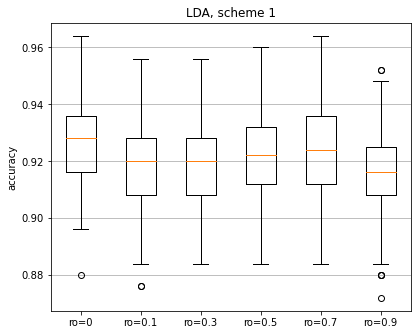

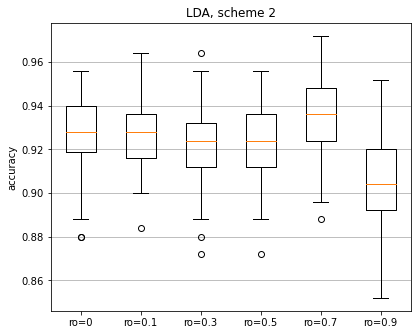

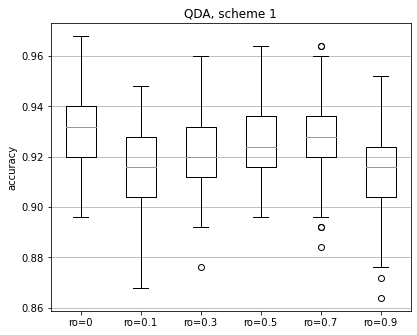

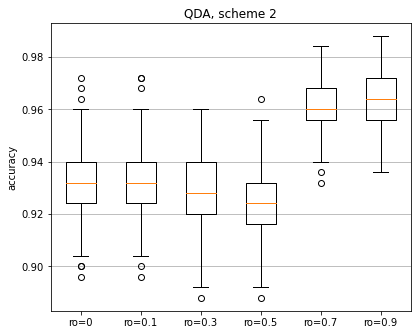

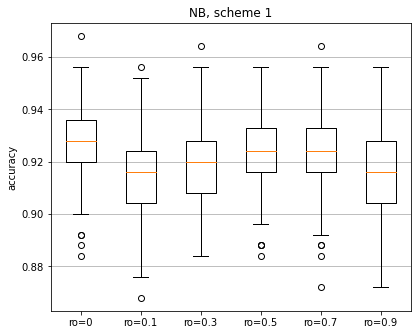

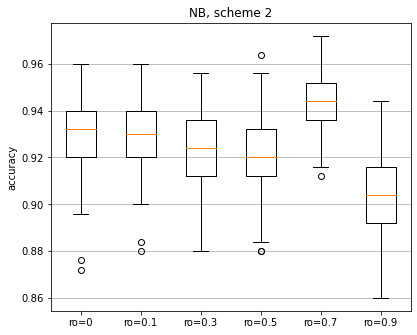

In [18]:
for model in ['LDA', 'QDA', 'NB']:
    for scheme in ['1', '2']:
        x = []
        for r in range(len(ro)):
            x.append(accuracys.get(model).get('scheme_' + scheme).get(ro[r]))

        fig = plt.figure(figsize =(5, 4))
        ax = fig.add_axes([0, 0, 1, 1])
        bp = ax.boxplot(x)
        plt.grid(axis='y')
        plt.title(model + ', scheme ' + scheme)
        ax.set_xticklabels(['ro='+str(r) for r in ro])
        plt.ylabel("accuracy")
        plt.savefig('task2/task_2_2_' + model + '_scheme' + scheme, bbox_inches='tight',
                    facecolor='white', transparent=False, pad_inches=0, dpi=200)
        plt.show()


## 2.3

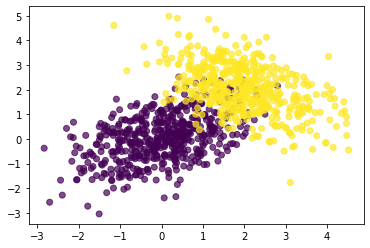

In [5]:
ro = 0.5
a = 2

df = scheme_2(a, ro, seed=213)
X_s2 = df.iloc[:, :2]
y_s2 = df.iloc[:, 2]

m_lda = LDA(X_s2, y_s2)
m_qda = QDA(X_s2, y_s2)

x = X_s2.iloc[:, 0]
y = X_s2.iloc[:, 1]

plt.scatter(x, y, c=y_s2, alpha=0.7)
plt.show()

In [6]:
minX, maxX, minY, maxY = -4, 7, -4, 7
coords = []
for x in np.linspace(minX, maxX, 500):
    for y in np.linspace(minY, maxY, 500):
        coords.append([x, y])

df = pd.DataFrame(coords)
df['pred_lda'] = m_lda.predict(df)
df['pred_qda'] = m_qda.predict(df.iloc[:, :2])

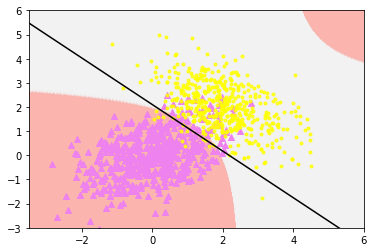

In [8]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1000)
clf.fit(df.iloc[:,:2].to_numpy(), df.iloc[:,2].to_numpy())

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-3.7, 6.3, 300)
yy = a * xx - (clf.intercept_[0]) / w[1]

x = X_s2.iloc[:, 0]
y = X_s2.iloc[:, 1]

plt.scatter(df.iloc[:, 0].to_numpy(), df.iloc[:, 1].to_numpy(),
            c=df.iloc[:, 3].to_numpy(), cmap="Pastel1")
plt.scatter(x[y_s2==0], y[y_s2==0], c='violet', marker='^', alpha=1)
plt.scatter(x[y_s2==1], y[y_s2==1], c='yellow', marker='.', alpha=0.8)
plt.plot(xx, yy, "k-")
plt.xlim([-3.5, 6])
plt.ylim([-3, 6])
plt.savefig('task2/task_2_3', bbox_inches='tight', facecolor='white', transparent=False, pad_inches=0, dpi=200)
plt.show()


# 3

1. https://archive.ics.uci.edu/ml/datasets/Cryotherapy+Dataset+

In [8]:
data = pd.read_excel('task3/data/Cryotherapy.xlsx')
y = data['Result_of_Treatment']
X = data.drop(columns=['Result_of_Treatment'])

np.random.seed(321)

accuracys = {'LDA': [], 
             'QDA': [],
             'NB': []}
for model in ['LDA', 'QDA', 'NB']:
    for r_state in np.random.randint(1, 50000, size=500):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=r_state)

        if model == 'LDA':
            m = LDA(X_train, y_train)
        elif model == 'QDA':
            m = QDA(X_train, y_train)
        elif model == 'NB':
            m = NB(X_train, y_train)

        acc = accuracy_score(m.predict(X_test), y_test)
        accuracys.get(model).append(acc)

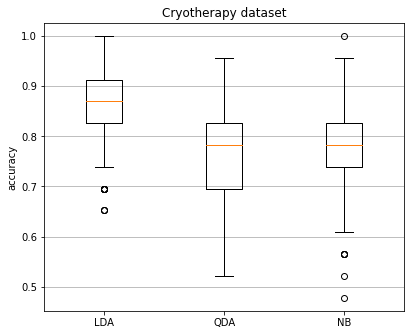

In [10]:
x = [accuracys.get('LDA'),
     accuracys.get('QDA'),
     accuracys.get('NB')]
fig = plt.figure(figsize =(5, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(x)
plt.grid(axis='y')
plt.title('Cryotherapy dataset')
ax.set_xticklabels(['LDA', 'QDA', 'NB'])
plt.ylabel("accuracy")
plt.savefig('task3/task_3_1', bbox_inches='tight', facecolor='white', transparent=False, pad_inches=0, dpi=200)
plt.show()

2. https://archive.ics.uci.edu/ml/datasets/Caesarian+Section+Classification+Dataset

In [14]:
df = pd.read_csv('task3/data/caesarian.csv.arff', skiprows=16, header=None)
X = df.iloc[:, :5]
y = df.iloc[:, 5]

np.random.seed(312)

accuracys = {'LDA': [], 
             'QDA': [],
             'NB': []}
for model in ['LDA', 'QDA', 'NB']:
    for r_state in np.random.randint(1, 50000, size=500):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=r_state)

        if model == 'LDA':
            m = LDA(X_train, y_train)
        elif model == 'QDA':
            m = QDA(X_train, y_train)
        elif model == 'NB':
            m = NB(X_train, y_train)

        acc = accuracy_score(m.predict(X_test), y_test)
        accuracys.get(model).append(acc)

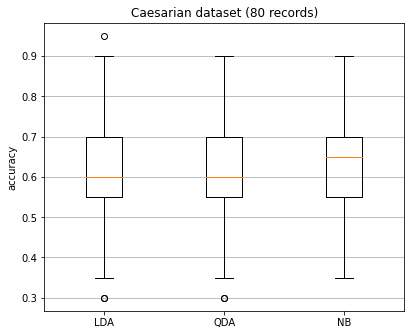

In [15]:
x = [accuracys.get('LDA'),
     accuracys.get('QDA'),
     accuracys.get('NB')]
fig = plt.figure(figsize =(5, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(x)
plt.grid(axis='y')
plt.title('Caesarian dataset (80 records)')
ax.set_xticklabels(['LDA', 'QDA', 'NB'])
plt.ylabel("accuracy")
plt.savefig('task3/task_3_2', bbox_inches='tight', facecolor='white', transparent=False, pad_inches=0, dpi=200)
plt.show()

3. https://archive.ics.uci.edu/ml/datasets/forest+fires

In [16]:
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('task3/data/forestfires.csv')
X = df.drop(columns=['month', 'X', 'Y', 'day', 'area', 'DMC'])
y = df['area']
y = (y > 0).astype(int)

In [17]:
np.random.seed(222)

accuracys = {'LDA': [], 
             'QDA': [],
             'NB': []}

for model in ['LDA', 'QDA', 'NB']:
    for r_state in np.random.randint(1, 50000, size=100):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=r_state)

        if model == 'LDA':
            m = LDA(X_train, y_train)
        elif model == 'QDA':
            m = QDA(X_train, y_train)
        elif model == 'NB':
            m = NB(X_train, y_train)

        try:
            acc = accuracy_score(m.predict(X_test), y_test)
            accuracys.get(model).append(acc)
        except:
            pass


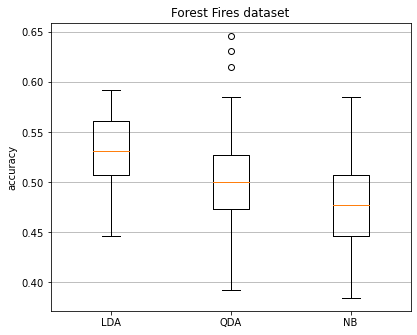

In [18]:
x = [accuracys.get('LDA'),
     accuracys.get('QDA'),
     accuracys.get('NB')]
fig = plt.figure(figsize =(5, 4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(x)
plt.grid(axis='y')
plt.title('Forest Fires dataset')
ax.set_xticklabels(['LDA', 'QDA', 'NB'])
plt.ylabel("accuracy")
plt.savefig('task3/task_3_3', bbox_inches='tight', facecolor='white', transparent=False, pad_inches=0, dpi=200)
plt.show()